# AML Project 3

# Imports

In [43]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Load Data

In [44]:
plant1 = pd.read_csv("Plant_1_Generation_Data.csv")
df = plant1.copy()

df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'], format="%d-%m-%Y %H:%M", dayfirst=True)
df = df.sort_values('DATE_TIME')

inv_daily = (
    df.groupby(['SOURCE_KEY', df['DATE_TIME'].dt.date])['DAILY_YIELD']
      .max()
      .reset_index()
      .rename(columns={'DATE_TIME': 'date'})
)

inv_daily['date'] = pd.to_datetime(inv_daily['date'])

daily = (
    inv_daily.groupby('date')['DAILY_YIELD']
             .sum()
             .reset_index()
             .rename(columns={'DAILY_YIELD':'daily_yield'})
)

# Engineer Features

In [45]:
# Basic time features
daily['dayofyear'] = daily['date'].dt.dayofyear
daily['month'] = daily['date'].dt.month
daily['week'] = daily['date'].dt.isocalendar().week.astype(int)
daily['weekday'] = daily['date'].dt.weekday
daily['is_weekend'] = daily['weekday'].isin([5,6]).astype(int)
daily['quarter'] = daily['date'].dt.quarter

# Lag features
for lag in [1,2,3,7,14]:
    daily[f'lag_{lag}'] = daily['daily_yield'].shift(lag)

# Rolling statistics
for window in [3,7,14]:
    daily[f'ma_{window}'] = daily['daily_yield'].rolling(window).mean()
    daily[f'std_{window}'] = daily['daily_yield'].rolling(window).std()

# Growth/change features
daily['diff_1'] = daily['daily_yield'].diff(1)
daily['diff_7'] = daily['daily_yield'].diff(7)
daily['pct_change_1'] = daily['daily_yield'].pct_change(1)
daily['pct_change_7'] = daily['daily_yield'].pct_change(7)

# Seasonal encoding
daily['sin_dayofyear'] = np.sin(2*np.pi*daily['dayofyear']/365)
daily['cos_dayofyear'] = np.cos(2*np.pi*daily['dayofyear']/365)

daily['daily_yield'] = daily['daily_yield'] / 1000  # Wh → kWh

# Train/Test Split

In [46]:
df_full = daily.copy()
df_full = df_full.dropna()   # drop lag/rolling NaNs

train = df_full.iloc[:-14]
test  = df_full.iloc[-14:]

X_train = train.drop(columns=['date','daily_yield'])
y_train = train['daily_yield']

X_test = test.drop(columns=['date','daily_yield'])
y_test = test['daily_yield']

print(X_test.isna().sum())

dayofyear        0
month            0
week             0
weekday          0
is_weekend       0
quarter          0
lag_1            0
lag_2            0
lag_3            0
lag_7            0
lag_14           0
ma_3             0
std_3            0
ma_7             0
std_7            0
ma_14            0
std_14           0
diff_1           0
diff_7           0
pct_change_1     0
pct_change_7     0
sin_dayofyear    0
cos_dayofyear    0
dtype: int64


# Preprocessing And Pipeline

In [59]:
model = Ridge(alpha=1.0)  # L2 regularization
model.fit(X_train, y_train)

Ridge()

# Prediction

In [60]:
preds = model.predict(X_test)

mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 5.437065846592608
RMSE: 6.798273615531392


In [61]:
results = pd.DataFrame({
    "date": test['date'],
    "actual": y_test.values,
    "predicted": preds
})

print(results)

         date      actual   predicted
20 2020-06-04  178.827542  173.041738
21 2020-06-05  168.529167  163.712266
22 2020-06-06  139.802000  141.070991
23 2020-06-07  168.197000  184.116860
24 2020-06-08  182.943000  188.750437
25 2020-06-09  176.854000  178.938732
26 2020-06-10  141.696000  143.432778
27 2020-06-11  123.626000  122.045736
28 2020-06-12  127.815000  128.473028
29 2020-06-13  185.308000  193.654502
30 2020-06-14  155.054000  148.388534
31 2020-06-15  147.615000  153.005872
32 2020-06-16  136.429000  131.499521
33 2020-06-17  129.571000  140.698809


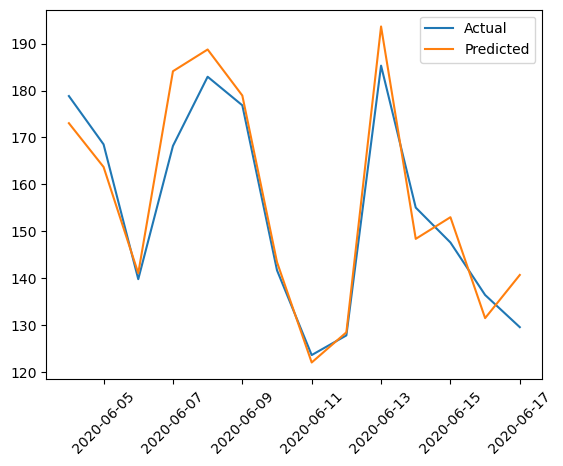

In [62]:
plt.plot(results['date'], results['actual'], label='Actual')
plt.plot(results['date'], results['predicted'], label='Predicted')
plt.legend()
plt.xticks(rotation=45)
plt.show()